In [1]:
!git clone https://github.com/reiinakano/scikit-plot.git && pip install scikit-plot

Cloning into 'scikit-plot'...
remote: Enumerating objects: 828, done.
remote: Total 828 (delta 0), reused 0 (delta 0), pack-reused 828
Receiving objects: 100% (828/828), 3.05 MiB | 0 bytes/s, done.
Resolving deltas: 100% (512/512), done.
Checking connectivity... done.
    100% |████████████████████████████████| 276kB 7.7MB/s ta 0:00:01
thinc 6.10.2 has requirement cytoolz<0.9,>=0.8, but you'll have cytoolz 0.9.0.1 which is incompatible.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn


In [36]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
con = sqlite3.connect('/mydata/final.sqlite')

In [5]:
final = pd.read_sql_query(""" SELECT * FROM Reviews""", con)

In [6]:
positive = final[final.Score == 'positive']
positive = positive.sample(frac=0.035,random_state=1)

negative = final[final.Score == 'negative']
negative = negative.sample(frac=0.15,random_state=1)

final = pd.concat([positive,negative],axis=0)

In [7]:
import datetime

final["Time"] = final["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [8]:
l = final['Score']
final = final.drop("Score", axis = 1)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final, l, test_size=0.3, random_state=0)

Training Word2Vec model using Text Corpus

In [10]:
def wordList(sentence):
    listword = []
    for sent in sentence:
        listword.append(sent.split())
    return listword
        

In [11]:
list_clean_text = wordList(X_train['CleanedText'].values)

In [12]:
list_clean_text_test = wordList(X_test['CleanedText'].values)

In [13]:
print(list_clean_text[1])

['dont', 'wast', 'money', 'newman', 'unless', 'want', 'weak', 'cup', 'decaf', 'coffe', 'cent', 'per', 'emeril', 'coffe', 'peopl', 'decaf', 'much', 'better', 'choic']


In [14]:
# Considering Words with minimum occurence of 5 times
w2v_model = Word2Vec(list_clean_text, min_count = 5, size = 50, workers = 2 )

In [15]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words occuring more than 5 times", len(w2v_words))
print("sample words", w2v_words[0:50])

number of words occuring more than 5 times 5407
sample words ['chorizo', 'small', 'skinni', 'dri', 'hard', 'time', 'cut', 'ad', 'flavor', 'practic', 'imposs', 'eat', 'chewi', 'dont', 'wast', 'money', 'newman', 'unless', 'want', 'weak', 'cup', 'decaf', 'coffe', 'cent', 'per', 'emeril', 'peopl', 'much', 'better', 'choic', 'everyon', 'know', 'use', 'pod', 'brewer', 'home', 'work', 'love', 'fresh', 'made', 'order', 'endless', 'varieti', 'etc', 'shame', 'mani', 'settl', 'big', 'roaster', 'like']


In [16]:
def w2vavg(clean,w2v_model,w2v_words):
    sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in clean:
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

        
#print(len(sent_vectors))
#print(len(sent_vectors[0]))
        

In [19]:
sent_vectors_train = w2vavg(list_clean_text,w2v_model,w2v_words)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

13519
50


In [20]:
sent_vectors_test = w2vavg(list_clean_text_test,w2v_model,w2v_words)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

5794
50


In [21]:
sent_vectors_final_train = np.asarray(sent_vectors_train)

In [22]:
sent_vectors_final_test = np.asarray(sent_vectors_test)

In [23]:
print(sent_vectors_final_train.shape)
print(sent_vectors_final_test.shape)

(13519, 50)
(5794, 50)


In [24]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()


In [25]:
standardized_data = s.fit_transform(sent_vectors_final_train)
standardized_data.shape

(13519, 50)

In [26]:
standardized_data_test = s.transform(sent_vectors_final_test)
standardized_data.shape

(13519, 50)

In [28]:
y_train.shape
y_test.shape

(5794,)

In [29]:
def kneigh(x,y,algo):
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))
    cv_scores = []
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k,algorithm=algo, n_jobs = -1) # Creating K-NN classifier with KD3 Algorithm
        scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())
     
    MSE = [1 - x for x in cv_scores]
    optimal_k = neighbors[MSE.index(min(MSE))]
    plt.plot(neighbors, MSE,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    
    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [34]:
def kneighpredict(k,x,y,z,algo):
    knn_optimal = KNeighborsClassifier(n_neighbors=k, algorithm=algo, n_jobs = -1)
    knn_optimal.fit(x, y)
    pred = knn_optimal.predict(z)
    acc = accuracy_score(y_test, pred) * 100
    skplt.plot_confusion_matrix(y_test ,pred)
    print(classification_report(y_test ,pred))
    return acc

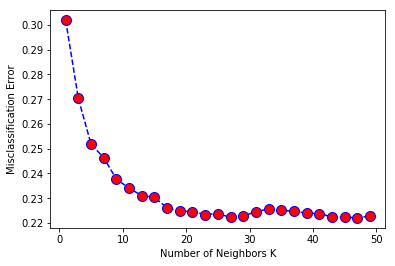

the misclassification error for each k value is :  [0.302 0.27  0.252 0.246 0.238 0.234 0.231 0.23  0.226 0.225 0.225 0.223
 0.224 0.222 0.223 0.225 0.226 0.225 0.225 0.224 0.224 0.222 0.222 0.222
 0.223]


In [31]:
optimal_k = kneigh(standardized_data,y_train,'kd_tree')


In [32]:
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 47.


             precision    recall  f1-score   support

   negative       0.77      0.69      0.73      2555
   positive       0.78      0.84      0.81      3239

avg / total       0.77      0.77      0.77      5794



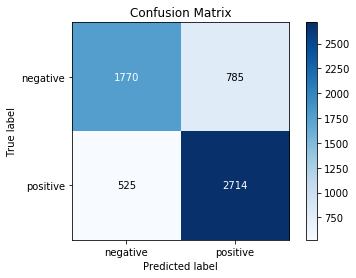

In [37]:
acc = kneighpredict(optimal_k,standardized_data,y_train,standardized_data_test ,'kd_tree')


In [38]:
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 47 is 77.390404%


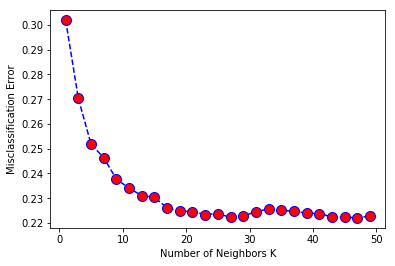

the misclassification error for each k value is :  [0.302 0.27  0.252 0.246 0.238 0.234 0.231 0.23  0.226 0.225 0.225 0.223
 0.224 0.222 0.223 0.225 0.226 0.225 0.225 0.224 0.224 0.222 0.222 0.222
 0.223]


In [39]:
optimal_k = kneigh(standardized_data,y_train,'brute')


In [40]:
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 47.


             precision    recall  f1-score   support

   negative       0.77      0.69      0.73      2555
   positive       0.78      0.84      0.81      3239

avg / total       0.77      0.77      0.77      5794



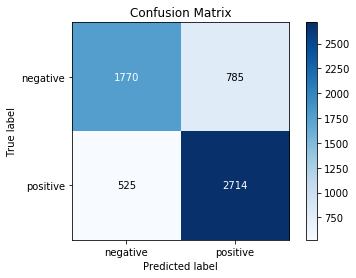

In [41]:
acc = kneighpredict(optimal_k,standardized_data,y_train,standardized_data_test ,'kd_tree')


In [42]:
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 47 is 77.390404%
